# Convergence

In [75]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)
import tarfile
import os
import pandas as pd

if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

### BASE CASE

In [76]:
# Model definition

from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


#Problem definition
problem = to_problem(model, searchover="levers")


In [77]:
#Run definition

nfe = 200000 #
seeds = 5
run_comment = 'BC'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BC_200000nfe_5seed'

In [78]:
#Change the load archives method of the ArchiveLogger class

import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives


In [79]:
#Merge convergences 

convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


column_names = ['Hydropower', 'Environment', 'Irrigation']

results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv") # Create the results list, containing dataframes with the results per seed 
    globals()[f'df_{i}'] = pd.read_csv(f"results_seed{i}.csv", usecols = column_names) # create dataframes per seed with results for analysis
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)



In [80]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.4] * len(model.outcomes), problem)  # [0.05]
len(reference_set)
#print('reference_set type is', type(reference_set))

126

In [7]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-03-13 22:44:13.849956


In [8]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)


KeyboardInterrupt: 

In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes
import matplotlib.pyplot as plt

for metrics, convergence in zip(metrics_by_seed, convergences):
    #plt.rcParams["font.family"] = "sans-serif"
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")    
    
    ax2.plot(metrics.nfe, metrics.hypervolume)
    ax2.set_ylabel("hypervolume")
    
sns.despine(fig)


plt.show()

after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

In [81]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

In [82]:
# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation']
df_bc = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()

# Create a dataframe without the column names for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]

#Save the best decisions for the simulation
path = f'../../decisions/basecase_{run_comment}/'
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_bc.Hydropower.max()
worst_irr = df_bc.Irrigation.max()
worst_env = df_bc.Environment.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_bc.Hydropower.min()
best_irr = df_bc.Irrigation.min()
best_env = df_bc.Environment.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [37]:
print(worst_list)

[20.17937625072075, 3214070.319504687, 3.074369590148062]


In [14]:
import tarfile
import os
import pandas as pd

column_names = ['Hydropower', 'Environment', 'Irrigation']

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0])

In [15]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    #print(archives)
    #all_archives.append(archives)
    '''
    sorted_archives = dict(sorted(archives.items()))
    for key, value in sorted_archives.items():
        #print(type(value))
        #normalized_value=(value-value.min())/(value.max()-value.min())
        o = value.values
        norm_o = normalized_value.values
        #print(type(o))
        #print(value)
        objs = np.ascontiguousarray(o)
        norm_objs = np.ascontiguousarray(norm_o)
        if key < 100:
            print('objs::',o)
            print('norm objs::',norm_o)
            print('worst array::', worst_array)
        #print(objs.shape)
        #array_reference_set = reference_set.values.copy()
        hv = hvwfg.wfg(objs, 
                       worst_array)
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            print('hv::',hv)
            print('norm_hv::',norm_hv)
        all_hvs.append(hv)
        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv
            hvs_dict_0[int(key)] = hv
        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv
            hvs_dict_1[int(key)] = hv
        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv
            hvs_dict_2[int(key)] = hv
        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv
            hvs_dict_3[int(key)] = hv
        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv
            hvs_dict_4[int(key)] = hv
        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv
            hvs_dict_5[int(key)] = hv
'''
    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)
        if key < 100:
            print('objs:', norm_objs)
            
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            print('norm_hv::',norm_hv)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    
    print('all hvs for seed', i, ':', norm_hvs_this_seed)
            #print("Key:", hv)#, "Value:", value)
norm_hvs_dict_0
    #all_hvs
#all_norm_hvs
    #for i in range(len(all_archives)):
#    print(i)
#print(all_archives)

norm_hv:: 0.07330550912985925
all hvs for seed 0 : [0.07330550912985925, 0.15488095747651823, 0.18134989834509632, 0.21936289577037313, 0.2231257281040233, 0.2417819324271439, 0.261452320969628, 0.2683027034169202, 0.28894281297230034, 0.3168967193852996, 0.33335055149986886, 0.34697048080541215, 0.3608336267449714, 0.3614604946197512, 0.3742494265377256, 0.39322747160532096, 0.40277416323697063, 0.41119238806197217, 0.42577700438750066, 0.4284727810315721, 0.4354640523115161, 0.4436081094349855, 0.45796021184913427, 0.4723261771673456, 0.4802654160088053, 0.48682486507492295, 0.49308055339071694, 0.49727326932914606, 0.5023724843884422, 0.5073684862314908, 0.5116937566655565, 0.5135056863041487, 0.5147409426184029, 0.5159193865625833, 0.5172602478092634, 0.5175394474148176, 0.5185374622644533, 0.5195162119905261, 0.5210110805928588, 0.5229446731783539, 0.523287625045012, 0.5254053179402502, 0.5272485166207082, 0.5314358030519443, 0.5308973102506557, 0.5326968250239644, 0.5333468211522

{100: 0.07330550912985925,
 1188: 0.15488095747651823,
 2279: 0.18134989834509632,
 3373: 0.21936289577037313,
 4467: 0.2231257281040233,
 5559: 0.2417819324271439,
 6659: 0.261452320969628,
 7757: 0.2683027034169202,
 8855: 0.28894281297230034,
 9856: 0.3168967193852996,
 10856: 0.33335055149986886,
 11859: 0.34697048080541215,
 12958: 0.3608336267449714,
 13958: 0.3614604946197512,
 14960: 0.3742494265377256,
 15963: 0.39322747160532096,
 17060: 0.40277416323697063,
 18061: 0.41119238806197217,
 19161: 0.42577700438750066,
 20361: 0.4284727810315721,
 21505: 0.4354640523115161,
 22642: 0.4436081094349855,
 23784: 0.45796021184913427,
 24922: 0.4723261771673456,
 26060: 0.4802654160088053,
 27198: 0.48682486507492295,
 28338: 0.49308055339071694,
 29481: 0.49727326932914606,
 30623: 0.5023724843884422,
 31765: 0.5073684862314908,
 32903: 0.5116937566655565,
 34046: 0.5135056863041487,
 35188: 0.5147409426184029,
 36328: 0.5159193865625833,
 37465: 0.5172602478092634,
 38606: 0.5175394

In [16]:
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Line {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

for key, value in sorted_archives.items():
    o = value
    print(o.type)
    #objs = np.ascontiguousarray(o)
    #print(objs.shape)
    #array_reference_set = reference_set.values.copy()
    #hv = hvwfg.wfg(objs, 
    #               worst_array)
    #print("Key:", hv)#, "Value:", value)

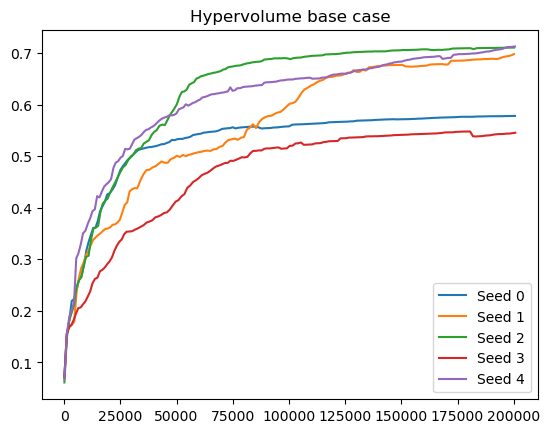

In [17]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.legend()

plt.title('Hypervolume base case')
relative_path = '../../plots'
filename = 'bc_hv.png'

# Show the plot
plt.show()


In [ ]:
os.getcwd()

# IRRIGATION CASE

In [83]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [85]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [86]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [87]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = ''
run_label = f"IR_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_200000nfe_5seed'

Change the load archives method of the ArchiveLogger class

In [88]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #print(archives)
    all_archives.append(archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
    print(len(result))
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.65] * len(model.outcomes), problem)  # [0.05]
len(reference_set)

216
179
291
234
252


111

In [89]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]

#Save the best decisions for the simulation
path = f'../../decisions/irr_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_irr.Hydropower.min()
best_irr = df_irr.Irrigation.min()
best_env = df_irr.Environment.min()
best_irr2 = df_irr.Irrigation2.min()
best_irr3 = df_irr.Irrigation3.min()
best_irr4 = df_irr.Irrigation4.min()
best_irr5 = df_irr.Irrigation5.min()
best_irr6 = df_irr.Irrigation6.min()
best_irr7 = df_irr.Irrigation7.min()
best_irr8 = df_irr.Irrigation8.min()
best_irr9 = df_irr.Irrigation9.min()

In [26]:
0000000print(worst_list)
.0

[25.74081684919041, 4069724.3081474174, 5.311067805215122, 0.7919088176780325, 0.8390991472490053, 0.7680897062118321, 0.5000834865006362, 0.7558803296248384, 0.5, 0.9166666666666666, 0.7829587508489807]


In [ ]:

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4, norm_hvs_dict_5]
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5]

for i in range(seeds):
    norm_hvs_this_seed = []
    hvs_this_seed = []

    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    for idx, (key, value) in enumerate(sorted(archives.items())):
        o = np.ascontiguousarray(value.values)
        hv = hvwfg.wfg(o, worst_array)
        hvs_this_seed.append(hv)

        hvs_dicts[idx][int(key)] = hv

    for idx, (key, value) in enumerate(sorted(norm_archives.items())):
        o = np.ascontiguousarray(value.values)
        norm_hv = hvwfg.wfg(o, norm_worst_array)
        norm_hvs_this_seed.append(norm_hv)

        norm_hvs_dicts[idx][int(key)] = norm_hv

    print(f'all norm hvs for seed {i}: {norm_hvs_this_seed}')

print(norm_hvs_dict_0)


In [ ]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}

norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}



for i in range(seeds):

    norm_hvs_this_seed = []
    hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    sorted_archives = dict(sorted(archives.items()))
    for key, value in sorted_archives.items():
        o = value.values
        objs = np.ascontiguousarray(o)
        hv = hvwfg.wfg(objs, 
                       worst_array)
        hvs_this_seed.append(hv)
        
        if i == 0 :
            hvs_dict_0[int(key)] = hv
        if i == 1 :
            hvs_dict_1[int(key)] = hv
        if i == 2 :
            hvs_dict_2[int(key)] = hv
        if i == 3 :
            hvs_dict_3[int(key)] = hv
        if i == 4 :
            hvs_dict_4[int(key)] = hv
        if i == 5 :
            hvs_dict_5[int(key)] = hv

    
    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)
            
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    
    print('all norm hvs for seed', i, ':', norm_hvs_this_seed)
    #print('all hvs for seed', i, ':', hvs_this_seed)
    
norm_hvs_dict_0


In [ ]:
#Normalized hypervolume
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.title('Hypervolume irrigation case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = 'irr_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()

In [ ]:
# Absolute hypervolume

hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

# IRRIGATION 1 million nfes, 1 seed
to compare hypervolume performance

In [25]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")


Run definition

In [26]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [27]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_mln_1000000nfe_1seed'

Change the load archives method of the ArchiveLogger class

In [28]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #print(archives)
    all_archives.append(archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
    print(len(result))
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.65] * len(model.outcomes), problem)  # [0.05]
len(reference_set)

329


175

In [29]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_mln_1000000nfe_1seed'

In [30]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]

#Save the best decisions for the simulation
path = f'../../decisions/irr_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_irr.Hydropower.min()
best_irr = df_irr.Irrigation.min()
best_env = df_irr.Environment.min()
best_irr2 = df_irr.Irrigation2.min()
best_irr3 = df_irr.Irrigation3.min()
best_irr4 = df_irr.Irrigation4.min()
best_irr5 = df_irr.Irrigation5.min()
best_irr6 = df_irr.Irrigation6.min()
best_irr7 = df_irr.Irrigation7.min()
best_irr8 = df_irr.Irrigation8.min()
best_irr9 = df_irr.Irrigation9.min()


In [31]:

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [32]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4, norm_hvs_dict_5]
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5]

for i in range(seeds):
    norm_hvs_this_seed = []
    hvs_this_seed = []

    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    for idx, (key, value) in enumerate(sorted(archives.items())):
        o = np.ascontiguousarray(value.values)
        hv = hvwfg.wfg(o, worst_array)
        hvs_this_seed.append(hv)

        hvs_dicts[idx][int(key)] = hv

    for idx, (key, value) in enumerate(sorted(norm_archives.items())):
        o = np.ascontiguousarray(value.values)
        norm_hv = hvwfg.wfg(o, norm_worst_array)
        norm_hvs_this_seed.append(norm_hv)

        norm_hvs_dicts[idx][int(key)] = norm_hv

    print(f'all norm hvs for seed {i}: {norm_hvs_this_seed}')

print(norm_hvs_dict_0)


In [33]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}

norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}



for i in range(seeds):

    norm_hvs_this_seed = []
    hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    sorted_archives = dict(sorted(archives.items()))
    for key, value in sorted_archives.items():
        o = value.values
        objs = np.ascontiguousarray(o)
        hv = hvwfg.wfg(objs, 
                       worst_array)
        hvs_this_seed.append(hv)
        
        if i == 0 :
            hvs_dict_0[int(key)] = hv
        if i == 1 :
            hvs_dict_1[int(key)] = hv
        if i == 2 :
            hvs_dict_2[int(key)] = hv
        if i == 3 :
            hvs_dict_3[int(key)] = hv
        if i == 4 :
            hvs_dict_4[int(key)] = hv
        if i == 5 :
            hvs_dict_5[int(key)] = hv

    
    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)
            
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    
    print('all norm hvs for seed', i, ':', norm_hvs_this_seed)
    #print('all hvs for seed', i, ':', hvs_this_seed)
    
norm_hvs_dict_0


all norm hvs for seed 0 : [0.0077384709307491955, 0.07922350090914113, 0.07972941211624196, 0.09604945298371374, 0.10890509526714273, 0.11073113643193, 0.111192145112677, 0.11296491428687984, 0.11402325648001803, 0.11394504693068298, 0.11653846037617588, 0.1191381075687431, 0.12102670415619012, 0.11872824201985514, 0.12055870325900729, 0.1326875121796572, 0.1368849606802399, 0.13693573972714884, 0.13693732204891548, 0.13705392878068515, 0.13424840731669732, 0.13452825400287163, 0.135114887465573, 0.1351419955039909, 0.13517959485298367, 0.13562491948471314, 0.15207673800466054, 0.15439645080449135, 0.1544001937722135, 0.1544193947025545, 0.16074981629683235, 0.162507491687955, 0.1626740497643016, 0.16757600222600008, 0.1675925045777077, 0.16759253339223815, 0.16364093836301313, 0.16443268038627695, 0.16563104511730933, 0.15630563100215397, 0.1569537930877543, 0.1626883965343013, 0.16782923302118882, 0.168056679123336, 0.17164844867637533, 0.16948304600747807, 0.17045241165426223, 0.170

{100: 0.0077384709307491955,
 1173: 0.07922350090914113,
 2262: 0.07972941211624196,
 3358: 0.09604945298371374,
 4358: 0.10890509526714273,
 5360: 0.11073113643193,
 6360: 0.111192145112677,
 7363: 0.11296491428687984,
 8366: 0.11402325648001803,
 9369: 0.11394504693068298,
 10419: 0.11653846037617588,
 11442: 0.1191381075687431,
 12464: 0.12102670415619012,
 13486: 0.11872824201985514,
 14509: 0.12055870325900729,
 15534: 0.1326875121796572,
 16557: 0.1368849606802399,
 17579: 0.13693573972714884,
 18602: 0.13693732204891548,
 19624: 0.13705392878068515,
 20648: 0.13424840731669732,
 21672: 0.13452825400287163,
 22697: 0.135114887465573,
 23718: 0.1351419955039909,
 24742: 0.13517959485298367,
 25764: 0.13562491948471314,
 26787: 0.15207673800466054,
 27813: 0.15439645080449135,
 28837: 0.1544001937722135,
 29860: 0.1544193947025545,
 30882: 0.16074981629683235,
 31905: 0.162507491687955,
 32926: 0.1626740497643016,
 33951: 0.16757600222600008,
 34972: 0.1675925045777077,
 36003: 0.1

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_mln_1000000nfe_1seed


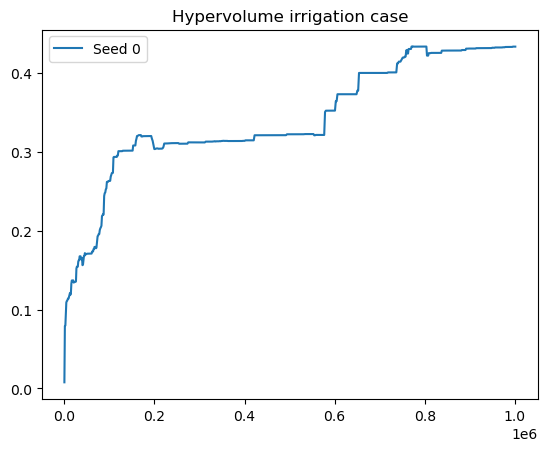

In [35]:
#Normalized hypervolume
norm_hvs_dicts = [norm_hvs_dict_0]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.title('Hypervolume irrigation case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()

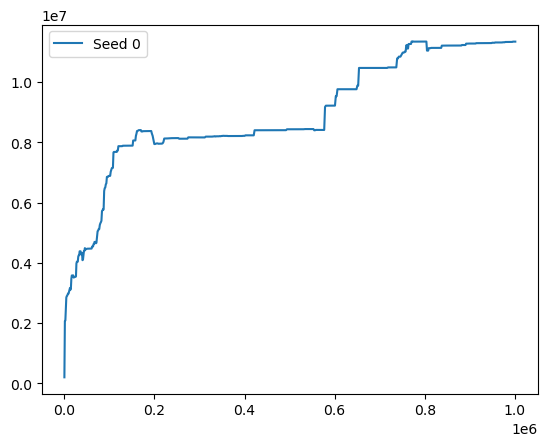

In [36]:
# Absolute hypervolume

hvs_dicts = [hvs_dict_0]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

# HYDROPOWER CASE

In [ ]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

In [ ]:
from model_zambezi_OPT_hyd import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]


In [ ]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [ ]:
os.getcwd()

In [ ]:

nfe = 200000 #
seeds = 5
run_comment = 'e4647'
run_label = f"HYD_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

Merge convergences 

In [ ]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]

In [ ]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]

In [ ]:
# Get the worst values (Nadir point)

# Load the merged results
#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']
df_hyd = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_hyd.Hydropower.max()
worst_irr = df_hyd.Irrigation.max()
worst_env = df_hyd.Environment.max()
worst_hydITT = df_hyd.HydropowerITT.max()
worst_hydKGU = df_hyd.HydropowerKGU.max()
worst_hydKA = df_hyd.HydropowerKA.max()
worst_hydCB = df_hyd.HydropowerCB.max()
worst_hydKGL = df_hyd.HydropowerKGL.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_hyd.Hydropower.min()
best_irr = df_hyd.Irrigation.min()
best_env = df_hyd.Environment.min()
best_hydITT = df_hyd.HydropowerITT.min()
best_hydKGU = df_hyd.HydropowerKGU.min()
best_hydKA = df_hyd.HydropowerKA.min()
best_hydCB = df_hyd.HydropowerCB.min()
best_hydKGL = df_hyd.HydropowerKGL.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [ ]:
print(worst_list)

In [ ]:
import tarfile
import os
import pandas as pd

#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                #norm_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)

        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    print('all hvs for seed', i, ':', norm_hvs_this_seed)
norm_hvs_dict_0


In [ ]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.title('Hypervolume hydrology case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = 'hyd_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


# FULL DISAGGREGATION CASE

In [69]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [70]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [71]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [72]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = '3'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_3_200000nfe_5seed'

In [73]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.9] * len(model.outcomes), problem)  # [0.05]
print(len(reference_set))

FileNotFoundError: [Errno 2] No such file or directory: 'convergence4.csv'

In [74]:
# Get the worst values (Nadir point)

# Load the merged results
#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']
df_full = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_full.Hydropower.max()
worst_irr = df_full.Irrigation.max()
worst_env = df_full.Environment.max()
worst_irr2 = df_full.Irrigation2.max()
worst_irr3 = df_full.Irrigation3.max()
worst_irr4 = df_full.Irrigation4.max()
worst_irr5 = df_full.Irrigation5.max()
worst_irr6 = df_full.Irrigation6.max()
worst_irr7 = df_full.Irrigation7.max()
worst_irr8 = df_full.Irrigation8.max()
worst_irr9 = df_full.Irrigation9.max()
worst_hydITT = df_full.HydropowerITT.max()
worst_hydKGU = df_full.HydropowerKGU.max()
worst_hydKA = df_full.HydropowerKA.max()
worst_hydCB = df_full.HydropowerCB.max()
worst_hydKGL = df_full.HydropowerKGL.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_full.Hydropower.min()
best_irr = df_full.Irrigation.min()
best_env = df_full.Environment.min()
best_irr2 = df_full.Irrigation2.min()
best_irr3 = df_full.Irrigation3.min()
best_irr4 = df_full.Irrigation4.min()
best_irr5 = df_full.Irrigation5.min()
best_irr6 = df_full.Irrigation6.min()
best_irr7 = df_full.Irrigation7.min()
best_irr8 = df_full.Irrigation8.min()
best_irr9 = df_full.Irrigation9.min()
best_hydITT = df_full.HydropowerITT.min()
best_hydKGU = df_full.HydropowerKGU.min()
best_hydKA = df_full.HydropowerKA.min()
best_hydCB = df_full.HydropowerCB.min()
best_hydKGL = df_full.HydropowerKGL.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)


FileNotFoundError: [Errno 2] No such file or directory: 'merged_results.csv'

In [43]:
print(worst_list)

[25.817718463596275, 4256444.726728774, 5.664975266747441, 0.7979347333580349, 0.8869867679983305, 0.8184277122531748, 0.5140971493407741, 0.7858880619359803, 0.5, 0.9166666666666666, 0.7908241042308518]


In [52]:
import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [53]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values
        norm_objs = np.ascontiguousarray(o)
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv
        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv
        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv
        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv
        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv
        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    print('all hvs for seed', i, ':', norm_hvs_this_seed)
norm_hvs_dict_0


all hvs for seed 0 : [0.0, 0.0003952720868514402, 0.0006554339930133879, 0.00039584306173593884, 0.0007006762183825245, 0.000701383045083419, 0.0007014570112983993, 0.0007016517064722767, 0.0007021841220561918, 0.0008288908826467914, 0.000777046004428032, 0.0006077192258747413, 0.000620654065907058, 0.000624982032268012, 0.0011314388366366794, 0.0016842610219951451, 0.0017230041530187144, 0.0017986613370094308, 0.0018059697084265827, 0.003006620392857076, 0.003278064913161031, 0.003118648887110516, 0.0031186852843868864, 0.003109418146434036, 0.003110649224986514, 0.003455799113817562, 0.0039445125894705104, 0.012047676957417385, 0.01297232584401051, 0.014982608740871338, 0.01650397169744174, 0.018437573966521948, 0.01851295272612156, 0.01970874311580554, 0.02051127177369968, 0.021409252538191578, 0.0214151346248983, 0.021629795394005436, 0.021757516881758348, 0.0217742430469276, 0.023888846096144757, 0.024201926542927618, 0.024431550042217698, 0.024452346373689853, 0.02397341596472269

{100: 0.0,
 1191: 0.0003952720868514402,
 2290: 0.0006554339930133879,
 3291: 0.00039584306173593884,
 4390: 0.0007006762183825245,
 5391: 0.000701383045083419,
 6391: 0.0007014570112983993,
 7395: 0.0007016517064722767,
 8398: 0.0007021841220561918,
 9402: 0.0008288908826467914,
 10602: 0.000777046004428032,
 11634: 0.0006077192258747413,
 12667: 0.000620654065907058,
 13699: 0.000624982032268012,
 14731: 0.0011314388366366794,
 15764: 0.0016842610219951451,
 16797: 0.0017230041530187144,
 17825: 0.0017986613370094308,
 18856: 0.0018059697084265827,
 19889: 0.003006620392857076,
 20924: 0.003278064913161031,
 21957: 0.003118648887110516,
 22986: 0.0031186852843868864,
 24018: 0.003109418146434036,
 25051: 0.003110649224986514,
 26085: 0.003455799113817562,
 27117: 0.0039445125894705104,
 28152: 0.012047676957417385,
 29187: 0.01297232584401051,
 30217: 0.014982608740871338,
 31248: 0.01650397169744174,
 32281: 0.018437573966521948,
 33311: 0.01851295272612156,
 34345: 0.01970874311580

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_1_200000nfe_5seed


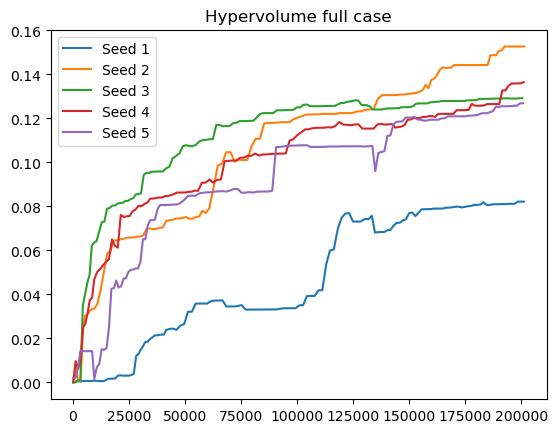

In [55]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i}')

plt.title('Hypervolume full case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv_norm.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


## FULL 1 mln case

In [57]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [58]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [59]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [60]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'mln'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_mln_1000000nfe_1seed'

In [61]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.9] * len(model.outcomes), problem)  # [0.05]
print(len(reference_set))

201


In [62]:
# Get the worst values (Nadir point)

# Load the merged results
#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']
df_full = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_full.Hydropower.max()
worst_irr = df_full.Irrigation.max()
worst_env = df_full.Environment.max()
worst_irr2 = df_full.Irrigation2.max()
worst_irr3 = df_full.Irrigation3.max()
worst_irr4 = df_full.Irrigation4.max()
worst_irr5 = df_full.Irrigation5.max()
worst_irr6 = df_full.Irrigation6.max()
worst_irr7 = df_full.Irrigation7.max()
worst_irr8 = df_full.Irrigation8.max()
worst_irr9 = df_full.Irrigation9.max()
worst_hydITT = df_full.HydropowerITT.max()
worst_hydKGU = df_full.HydropowerKGU.max()
worst_hydKA = df_full.HydropowerKA.max()
worst_hydCB = df_full.HydropowerCB.max()
worst_hydKGL = df_full.HydropowerKGL.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_full.Hydropower.min()
best_irr = df_full.Irrigation.min()
best_env = df_full.Environment.min()
best_irr2 = df_full.Irrigation2.min()
best_irr3 = df_full.Irrigation3.min()
best_irr4 = df_full.Irrigation4.min()
best_irr5 = df_full.Irrigation5.min()
best_irr6 = df_full.Irrigation6.min()
best_irr7 = df_full.Irrigation7.min()
best_irr8 = df_full.Irrigation8.min()
best_irr9 = df_full.Irrigation9.min()
best_hydITT = df_full.HydropowerITT.min()
best_hydKGU = df_full.HydropowerKGU.min()
best_hydKA = df_full.HydropowerKA.min()
best_hydCB = df_full.HydropowerCB.min()
best_hydKGL = df_full.HydropowerKGL.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)


In [63]:
print(worst_list)

[24.992408755518063, 4804677.179012956, 5.598141238596542, 0.7988606592839607, 0.83991698471457, 0.8038405106186434, 0.5114980894405021, 0.7208247210902681, 0.5, 0.9166666666666666, 0.7892414957677202]


In [64]:
import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [66]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values
        norm_objs = np.ascontiguousarray(o)
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv
        elif i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv
        elif i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv
        elif i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv
        elif i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv
        elif i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    print('all hvs for seed', i, ':', norm_hvs_this_seed)
norm_hvs_dict_0


all hvs for seed 0 : [0.00012361426432227755, 4.874755675568052e-05, 0.0001590593944516163, 1.1918611750484684e-05, 0.0006269418248795219, 0.0007482916112295844, 0.0008248862085576064, 0.004743788116547468, 0.004747425943360725, 0.006455435541348517, 0.0060891918318991154, 0.023891215365765613, 0.02945645134962244, 0.029732054182890304, 0.03050906864227382, 0.025137875230969255, 0.025478004923442106, 0.02831468704847925, 0.029354961625118404, 0.035322313938917285, 0.03532231604190019, 0.035350134349479985, 0.03535782064651487, 0.03536124955205254, 0.04150723199592019, 0.041504940443192403, 0.04637199043733694, 0.04633220448683113, 0.04606420436084737, 0.04875888991345684, 0.04968143997853547, 0.05030633965297149, 0.050322583304000516, 0.05058754884877213, 0.050651300898698536, 0.05065412457657114, 0.0525983337907163, 0.05343322532349899, 0.05346606759402853, 0.05386522381855029, 0.05386522382677059, 0.05249200307562166, 0.057682811170740755, 0.05988566125654256, 0.058689291113162415, 0

{100: 0.00012361426432227755,
 1190: 4.874755675568052e-05,
 2190: 0.0001590593944516163,
 3194: 1.1918611750484684e-05,
 4292: 0.0006269418248795219,
 5392: 0.0007482916112295844,
 6395: 0.0008248862085576064,
 7401: 0.004743788116547468,
 8402: 0.004747425943360725,
 9404: 0.006455435541348517,
 10657: 0.0060891918318991154,
 11770: 0.023891215365765613,
 12878: 0.02945645134962244,
 13991: 0.029732054182890304,
 15105: 0.03050906864227382,
 16217: 0.025137875230969255,
 17334: 0.025478004923442106,
 18450: 0.02831468704847925,
 19563: 0.029354961625118404,
 20680: 0.035322313938917285,
 21795: 0.03532231604190019,
 22910: 0.035350134349479985,
 24027: 0.03535782064651487,
 25143: 0.03536124955205254,
 26260: 0.04150723199592019,
 27375: 0.041504940443192403,
 28489: 0.04637199043733694,
 29607: 0.04633220448683113,
 30725: 0.04606420436084737,
 31843: 0.04875888991345684,
 32957: 0.04968143997853547,
 34074: 0.05030633965297149,
 35191: 0.050322583304000516,
 36305: 0.05058754884877

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_mln_1000000nfe_1seed


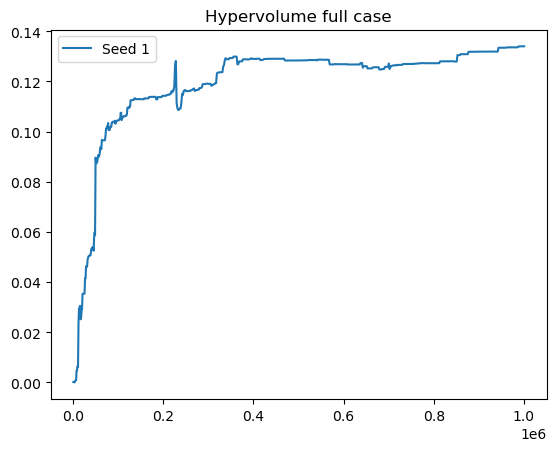

In [68]:
norm_hvs_dicts = [norm_hvs_dict_0]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i}')

plt.title('Hypervolume full case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv_norm.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()
